#Import Dataset From Kaggal

In [7]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir -p ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [9]:
# List available datasets.
!kaggle datasets list

ref                                                            title                                                size  lastUpdated          downloadCount  
-------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
utkarshxy/who-worldhealth-statistics-2020-complete             World Health 2020 🌏 | For Geospatial Analysis         1MB  2021-01-04 13:50:40            469  
gpreda/pfizer-vaccine-tweets                                   Pfizer Vaccine Tweets                               363KB  2021-01-03 20:16:38            303  
google/android-smartphones-high-accuracy-datasets              Android smartphones high accuracy GNSS datasets       1GB  2020-12-23 01:51:11             70  
ashkhagan/women-representation-in-city-property-sanfrancisco   Women Representation in City Property SanFrancisco    3KB  2020-12-13 05:18:14             71  
arashnic/covid19-case-surveillance-public-use-

In [10]:
! kaggle datasets download -d pcbreviglieri/pneumonia-xray-images

 99% 1.13G/1.14G [00:25<00:00, 65.4MB/s]
100% 1.14G/1.14G [00:25<00:00, 48.1MB/s]


In [11]:
#Un-Zip Data
import zipfile
zf = '/content/pneumonia-xray-images.zip'
target_dir = '/content/dataset/CNN/pneumonia-revamped'
zfile = zipfile.ZipFile(zf)
zfile.extractall(target_dir)

In [12]:
#Import Libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#Define Directories of Train / Test and Validation Set
train_path = '/content/dataset/CNN/pneumonia-revamped/train'
test_path = '/content/dataset/CNN/pneumonia-revamped/test'
valid_path = '/content/dataset/CNN/pneumonia-revamped/val'

#Define Often used standard parameters
batch_size=16 #Trainig Example in 1 iteration
img_ht = 500
img_wt = 500

#Preparing the Data
##Data Augmentation

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
img_gen = ImageDataGenerator(rescale=1./255,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True)

#Create Image Data Generator from Test / Validation
test_data_gen = ImageDataGenerator(rescale=1./255)

#Load Images

In [14]:
train = img_gen.flow_from_directory(train_path,
                                    target_size=(img_ht, img_wt),
                                    color_mode='grayscale',
                                    class_mode='binary',
                                    batch_size=batch_size)
test = test_data_gen.flow_from_directory(test_path,
                                         target_size=(img_ht, img_wt),
                                         color_mode='grayscale',
                                         shuffle=False,
                                         class_mode='binary',
                                         batch_size=batch_size)
valid = test_data_gen.flow_from_directory(valid_path,
                                          target_size=(img_ht, img_wt),
                                          color_mode='grayscale',
                                          class_mode='binary',
                                          batch_size=batch_size)

Found 4192 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 1040 images belonging to 2 classes.


#take a Look at some of the training Examples

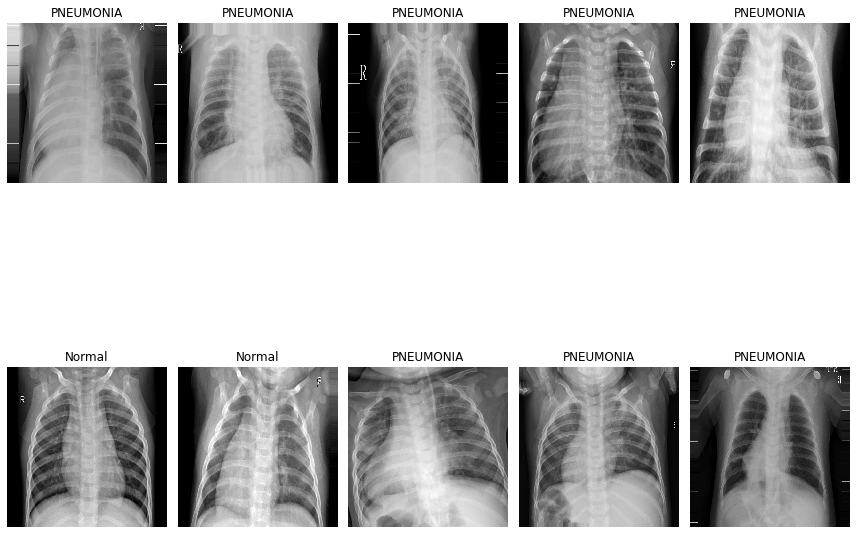

In [15]:
plt.figure(figsize=(12,12))
for i in range(10):
  plt.subplot(2,5,i+1)
  for X_batch, Y_batch in train:
    img = X_batch[0]
    dic = {0:'Normal', 1:'PNEUMONIA'}
    plt.title(dic.get(Y_batch[0]))
    plt.axis('off')
    plt.imshow(np.squeeze(img),cmap='gray', interpolation='nearest')
    break
plt.tight_layout()
plt.show()


#Import Tensorflow Libraries

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

#Make CNN Architecture

In [21]:
cnn = Sequential()
cnn.add(Conv2D(32, (3,3), activation='relu', input_shape=(img_wt, img_ht, 1)))
cnn.add(MaxPooling2D((2,2)))
cnn.add(Conv2D(64, (3,3), activation='relu'))
cnn.add(MaxPooling2D((2,2)))
cnn.add(Conv2D(128, (3,3), activation='relu'))
cnn.add(MaxPooling2D((2,2)))
cnn.add(Conv2D(256, (3,3), activation='relu'))
cnn.add(MaxPooling2D((2,2)))
cnn.add(Conv2D(512, (3,3), activation='relu'))
cnn.add(MaxPooling2D((2,2)))
cnn.add(Flatten())
cnn.add(Dense(activation='relu', units=128))
cnn.add(Dense(activation='relu', units=64))
cnn.add(Dense(activation='sigmoid', units=1))
cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#Develop CNN Model

In [22]:
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 498, 498, 32)      320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 249, 249, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 247, 247, 64)      18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 123, 123, 64)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 121, 121, 128)     73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 60, 60, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 58, 58, 256)      

#Visualize CNN Model

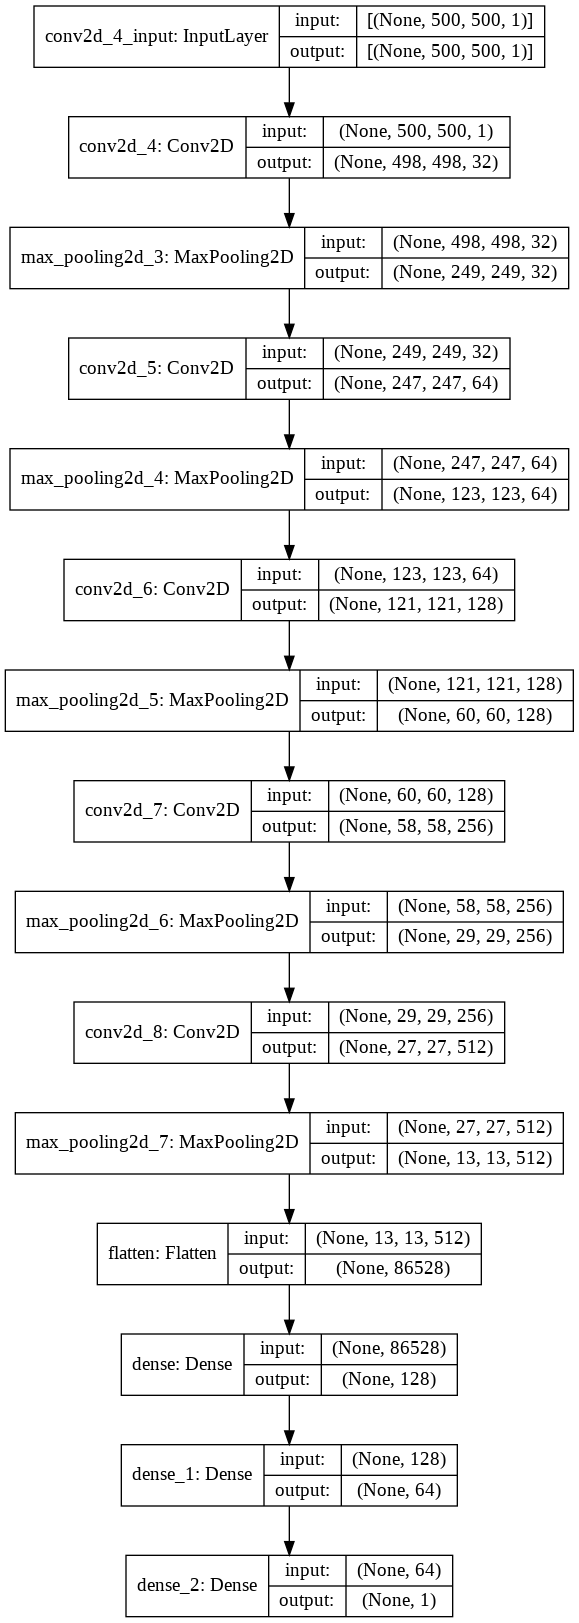

In [23]:
from tensorflow.keras.utils import plot_model
plot_model(cnn, show_shapes=True,
           show_layer_names=True,
           rankdir='TB',
           expand_nested=True)

#Defining Callback List

In [26]:
early = EarlyStopping(monitor='val_loss', mode='min', patience=5)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)
callbacks_list = [early, learning_rate_reduction]

#Assigning Class Weights

In [27]:
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight('balanced', np.unique(train.classes), train.classes)
cw = dict(zip(np.unique(train.classes), weights))
print(cw)

{0: 1.9371534195933457, 1: 0.6739549839228296}


#Train our Model

In [28]:
cnn.fit(train, epochs=25, validation_data=valid, class_weight=cw,
        callbacks=callbacks_list)

Epoch 1/25
262/262 [==============================] - 116s 416ms/step - loss: 0.6793 - accuracy: 0.5010 - val_loss: 0.4795 - val_accuracy: 0.8365
Epoch 2/25
262/262 [==============================] - 109s 415ms/step - loss: 0.3885 - accuracy: 0.8266 - val_loss: 0.3072 - val_accuracy: 0.9173
Epoch 3/25
262/262 [==============================] - 107s 410ms/step - loss: 0.2705 - accuracy: 0.8894 - val_loss: 0.1777 - val_accuracy: 0.9317
Epoch 4/25
262/262 [==============================] - 107s 408ms/step - loss: 0.2434 - accuracy: 0.9044 - val_loss: 0.2164 - val_accuracy: 0.9125
Epoch 5/25
262/262 [==============================] - 107s 407ms/step - loss: 0.1984 - accuracy: 0.9169 - val_loss: 0.1696 - val_accuracy: 0.9365
Epoch 6/25
262/262 [==============================] - 107s 407ms/step - loss: 0.1928 - accuracy: 0.9166 - val_loss: 0.1752 - val_accuracy: 0.9202
Epoch 7/25
262/262 [==============================] - 107s 409ms/step - loss: 0.1693 - accuracy: 0.9344 - val_loss: 0.1988 -

#Evalutaion

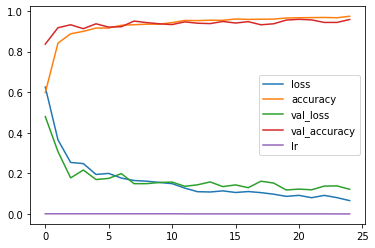

In [29]:
pd.DataFrame(cnn.history.history).plot()

In [30]:
test_accu = cnn.evaluate(test)

39/39 [==============================] - 5s 125ms/step - loss: 0.2798 - accuracy: 0.9199


In [31]:
print('The Testing Accuracy is: ', test_accu[1]*100, "%")

The Testing Accuracy is:  91.98718070983887 %


In [32]:
preds = cnn.predict(test, verbose=1)

39/39 [==============================] - 5s 124ms/step


In [33]:
predictions = preds.copy()
predictions[predictions<=0.5] = 0
predictions[predictions>0.5] = 1

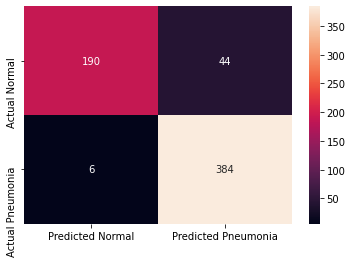

In [35]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
cm = pd.DataFrame(data=confusion_matrix(test.classes, predictions, labels=[0,1]),
                  index=['Actual Normal', 'Actual Pneumonia'],
                  columns=['Predicted Normal', 'Predicted Pneumonia'])
sns.heatmap(cm,annot=True, fmt='d')